Convert electron photon dataset from h5py files to single npz file with train test splitted

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [2]:
with h5py.File("/content/drive/My Drive/electron-photon-dataset/photon.hdf5", "r") as f:
  px = np.asarray(f['X'][()], dtype=np.float32)
  py = np.asarray(f['y'][()], dtype=np.float32)
  print("Loaded photon dataset!")

with h5py.File("/content/drive/My Drive/electron-photon-dataset/electron.hdf5", "r") as f:
  ex = np.asarray(f['X'][()], dtype=np.float32)
  ey = np.asarray(f['y'][()], dtype=np.float32)
  print("Loaded electron dataset!")

print("Photon dataset shape:", px.shape, py.shape)
print("Electron dataset shape:", ex.shape, ey.shape)

Loaded photon dataset!
Loaded electron dataset!
Photon dataset shape: (249000, 32, 32, 2) (249000,)
Electron dataset shape: (249000, 32, 32, 2) (249000,)


In [3]:
print(px.shape, py.shape)
print(ex.shape, ey.shape)

(249000, 32, 32, 2) (249000,)
(249000, 32, 32, 2) (249000,)


In [4]:
py.max(), py.min()

(0.0, 0.0)

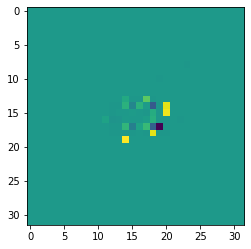

In [5]:
plt.imshow(px[0, :, :, 1])

In [6]:
x = np.concatenate((px,ex), axis =0)
y = np.concatenate((py,ey), axis= 0)
del px,ex,py,ey
print(x.shape)
print(y.shape)

(498000, 32, 32, 2)
(498000,)


In [7]:
x, y = shuffle(x,y)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.15, random_state=42)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
del x, y

(423300, 32, 32, 2) (423300,)
(74700, 32, 32, 2) (74700,)


In [9]:
np.savez_compressed('/content/electron-photon-large.npz', **{
    'x_train': x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test
})

In [10]:
del x_train, x_test, y_train, y_test

In [11]:
data = np.load('/content/electron-photon-large.npz', allow_pickle=True)

Download the dataset from sidebar

In [13]:
data['x_train'].shape

(423300, 32, 32, 2)